In [1]:
import numpy as np
import tensorflow as tf
import strawberryfields as sf

In [2]:
sf.__version__

'0.15.1'

In [23]:
def test_sf(cutoff_dim):
    eng = sf.Engine('fock', backend_options={'cutoff_dim':cutoff_dim})

    gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    gamma2 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    phi1 = np.random.normal(scale=0.01)
    phi2 = np.random.normal(scale=0.01)
    theta1 = np.random.normal(scale=0.01)
    varphi1 = np.random.normal(scale=0.01)
    zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    zeta2 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    theta = np.random.normal(scale=0.01)
    varphi = np.random.normal(scale=0.01)
    
    prog = sf.Program(2)
    gamma1r = np.abs(gamma1)
    gamma1phi = np.angle(gamma1)
    gamma2r = np.abs(gamma2)
    gamma2phi = np.angle(gamma2)
    with prog.context as mode:
        sf.ops.Dgate(gamma1r,phi=gamma1phi) | mode[0]
        sf.ops.Dgate(gamma2r,phi=gamma2phi) | mode[1]
        sf.ops.Rgate(phi1) | mode[0]
        sf.ops.Rgate(phi2) | mode[1]
        sf.ops.BSgate(theta1,varphi1) | mode
        sf.ops.Sgate(zeta1) | mode[0]
        sf.ops.Sgate(zeta2) | mode[1]
        sf.ops.BSgate(theta,varphi) | mode
    state_out = eng.run(prog).state.ket()
    
    return state_out

In [10]:
import numpy as np
from numba import jit

@jit(nopython=True) #np.dot does not work with numba
def C_mu_Sigma(gamma1, gamma2, phi1, phi2, theta1, varphi1, zeta1, zeta2, theta, varphi):
    """
    Utility function to construct:
    1. C constant
    2. Mu vector
    3. Sigma matrix

    Arguments:
        gamma1 (complex): displacement parameter1
        gamma2 (complex): displacement parameter2
        phi1 (float): phase rotation parameter1
        phi2 (float): phase rotation parameter2
        
        theta1(float): transmissivity angle of the beamsplitter1
        varphi1(float): reflection phase of the beamsplitter1
        
        zeta1 (complex): squeezing parameter1
        zeta2 (complex): squeezing parameter2
        
        theta(float): transmissivity angle of the beamsplitter
        varphi(float): reflection phase of the beamsplitter

    Returns:
        C (complex), mu (complex array[4]), Sigma (complex array[4,4])
    """
    
    gamma1c = np.conj(gamma1)
    gamma2c = np.conj(gamma2)
    r1 = np.abs(zeta1)
    r2 = np.abs(zeta2)
    delta1 = np.angle(zeta1)
    delta2 = np.angle(zeta2)
    
    e_iphi1 = np.exp(1j*phi1)
    e_iphi2 = np.exp(1j*phi2)
    e_iphi12 = np.exp(1j*(phi1+phi2))
    e_ivarphi1 = np.exp(1j*varphi1)
    e_ivarphi = np.exp(1j*varphi)
    e_idelta1 = np.exp(1j*delta1)
    e_idelta2 = np.exp(1j*delta2)
    
    cos_theta1 = np.cos(theta1)
    sin_theta1 = np.sin(theta1)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    tanh_r1 = np.tanh(r1)
    tanh_r2 = np.tanh(r2)
    cosh_r1 = np.cosh(r1)
    cosh_r2 = np.cosh(r2)
    
    T1 = np.exp(1j*delta1)*np.tanh(r1)
    T2 = np.exp(1j*delta2)*np.tanh(r2)
    T1minus = np.exp(-1j*delta1)*np.tanh(r1)
    T2minus = np.exp(-1j*delta2)*np.tanh(r2)

    W = np.array([[e_iphi1*cos_theta1 , -e_iphi1/e_ivarphi1*sin_theta1],[e_iphi2*e_ivarphi1*sin_theta1, e_iphi2*cos_theta1]] ,dtype = np.complex128)
    V = np.array([[cos_theta , -1/e_ivarphi*sin_theta],[e_ivarphi*sin_theta, cos_theta]],dtype = np.complex128)

    WdiagWT = np.array([[e_idelta1*e_iphi1**2*cos_theta1**2*tanh_r1 + e_idelta2*e_iphi1**2/e_ivarphi1**2*sin_theta1**2*tanh_r2, e_idelta1*e_iphi12*e_ivarphi1*cos_theta1*sin_theta1*tanh_r1 - e_idelta2*e_iphi12/e_ivarphi1*cos_theta1*sin_theta1*tanh_r2],[ e_idelta1*e_iphi12*e_ivarphi1*cos_theta1*sin_theta1*tanh_r1 - e_idelta2*e_iphi12/e_ivarphi1*cos_theta1*sin_theta1*tanh_r2, e_idelta1*e_iphi2**2*e_ivarphi1**2*sin_theta1**2*tanh_r1+e_idelta2*e_iphi2**2*cos_theta1**2*tanh_r2]],dtype = np.complex128)
    
    WdiagsV = np.array([[ e_iphi1*cos_theta1*cos_theta/cosh_r1 - e_iphi1*e_ivarphi/e_ivarphi1*sin_theta*sin_theta1/cosh_r2 ,  -e_iphi1/e_ivarphi*cos_theta1*sin_theta/cosh_r1 - e_iphi1/e_ivarphi1*cos_theta*sin_theta1/cosh_r2],[e_iphi2*e_ivarphi*cos_theta1*sin_theta/cosh_r2 + e_iphi2*e_ivarphi1*cos_theta*sin_theta1/cosh_r1     ,  e_iphi2*cos_theta1*cos_theta/cosh_r2 - e_iphi2*e_ivarphi1/e_ivarphi*sin_theta*sin_theta1/cosh_r1   ]],dtype = np.complex128)
    
    VTdiagminusV = np.array([[1/e_idelta1*cos_theta**2*tanh_r1 + 1/e_idelta2*e_ivarphi**2*sin_theta**2*tanh_r2, -1/e_idelta1/e_ivarphi*cos_theta*sin_theta*tanh_r1 + 1/e_idelta2*e_ivarphi*sin_theta*cos_theta*tanh_r2],[ -1/e_idelta1/e_ivarphi*cos_theta*sin_theta*tanh_r1 + 1/e_idelta2*e_ivarphi*sin_theta*cos_theta*tanh_r2, 1/e_idelta1/e_ivarphi**2*sin_theta**2*tanh_r1 + 1/e_idelta2*cos_theta**2*tanh_r2]],dtype = np.complex128)
 
    Cpart2 = (gamma1c*WdiagWT[0,0] + gamma2c * WdiagWT[1,0]) * gamma1c + (gamma1c*WdiagWT[0,1] + gamma2c * WdiagWT[1,1]) * gamma2c
    C = np.exp(-0.5*(np.abs(gamma1)**2+np.abs(gamma2)**2 +Cpart2))/ np.sqrt(cosh_r1*cosh_r2)
    
    mu = np.zeros(4, dtype = np.complex128)
    
    mu[0] = gamma1c* WdiagWT[0,0] + gamma2c*WdiagWT[1,0] + gamma1
    mu[1] = gamma1c* WdiagWT[0,1] + gamma2c*WdiagWT[1,1] + gamma2
    mu[2] = -(gamma1c* WdiagsV[0,0] + gamma2c*WdiagsV[1,0])
    mu[3] = -(gamma1c* WdiagsV[0,1] + gamma2c*WdiagsV[1,1])

    W1 = WdiagWT
    W2 = -WdiagsV
    W3 = np.transpose(W2)
    W4 = -VTdiagminusV
    Sigma = np.concatenate((np.concatenate( (W1,W2) ,axis=1),np.concatenate((W3, W4),axis=1))) 
    
    return C, mu, Sigma

@jit(nopython=True)
def R_matrix(gamma1, gamma2, phi1, phi2, theta1, varphi1, zeta1, zeta2, theta, varphi, Psi):
    """
    Directly constructs the transformed state recursively and exactly.

    Arguments:
        gamma1 (complex): displacement parameter1
        gamma2 (complex): displacement parameter2
        phi1 (float): phase rotation parameter1
        phi2 (float): phase rotation parameter2
        
        theta1(float): transmissivity angle of the beamsplitter1
        varphi1(float): reflection phase of the beamsplitter1
        
        zeta1 (complex): squeezing parameter1
        zeta2 (complex): squeezing parameter2
        
        theta(float): transmissivity angle of the beamsplitter
        varphi(float): reflection phase of the beamsplitter
        
        Psi(np.array(complex)): State to be transformed

    Returns:
        R (complex array[D,D,D,D]): the matrix where R[:,:,0,0] is the transformed state 
    """
    C, mu ,Sigma = C_mu_Sigma(gamma1, gamma2, phi1, phi2, theta1, varphi1, zeta1, zeta2, theta, varphi)

    cutoff = Psi.shape[0]
    dtype = Psi.dtype

    sqrt = np.sqrt(np.arange(cutoff, dtype = np.complex128))
    sqrtT = sqrt.reshape(-1, 1)


    R = np.zeros((cutoff, cutoff, cutoff+1, cutoff+1), dtype = np.complex128)
    G_00pq = np.zeros((cutoff, cutoff), dtype = np.complex128)
    
    
    #G_mn00
    G_00pq[0,0] = C
    for q in range(1, cutoff):
        G_00pq[0,q] = (mu[3]*G_00pq[0,q-1] - Sigma[3,3]*sqrt[q-1]*G_00pq[0,q-2])/sqrt[q]


    for p in range(1,cutoff):
        for q in range(0,cutoff):
            G_00pq[p,q] = (mu[2]*G_00pq[p-1,q] - Sigma[2,2]*sqrt[p-1]*G_00pq[p-2,q] - Sigma[2,3]*sqrt[q]*G_00pq[p-1,q-1])/sqrt[p]
                    
    # R_00^jk = a_dagger^j \G_00pq> b^k  * |old_state>

#     for j in range(cutoff):
#         for k in range(cutoff):
#             G_00pq2 = G_00pq
#             for i in range(k):
#                 G_00pq2 = G_00pq2[:,:-1]*sqrt[i+1:]
#             for i in range(j):
#                 #G_00pq2 = sqrt[i+1:,None]*G_00pq2[:-1,:] sqrt[i+1:,None]doesnt work with numba
#                 G_00pq2 = sqrtT[i+1:]*G_00pq2[:-1,:]
#             R[0,0,j,k] = np.sum(G_00pq2*Psi[j:,k:])

    G_00pq2 = G_00pq
    for j in range(cutoff):
        G_00pq3 = G_00pq2
        for k in range(cutoff):
            R[0,0,j,k] = np.sum(G_00pq3*Psi[j:,k:])
            G_00pq3 = G_00pq3[:,:-1]*sqrt[k+1:]
        G_00pq2 = sqrtT[j+1:]*G_00pq2[:-1,:]


    #R_0n^jk
    for n in range(1,cutoff):
        for k in range(0,cutoff): 
            for j in range(0,cutoff):
                R[0,n,j,k] = mu[1]/sqrt[n]*R[0,n-1,j,k] - Sigma[1,1]/sqrt[n]*sqrt[n-1]*R[0,n-2,j,k] - Sigma[1,2]/sqrt[n]*R[0,n-1,j+1,k] - Sigma[1,3]/sqrt[n]*R[0,n-1,j,k+1]


    for m in range(1,cutoff):
        for n in range(0,cutoff):
            for j in range(0,cutoff-m):
                for k in range(0,cutoff-m-j):
                    R[m,n,j,k] = mu[0]/sqrt[m]*R[m-1,n,j,k] - Sigma[0,0]/sqrt[m]*sqrt[m-1]*R[m-2,n,j,k] - Sigma[0,1]*sqrt[n]/sqrt[m]*R[m-1,n-1,j,k] - Sigma[0,2]/sqrt[m]*R[m-1,n,j+1,k] - Sigma[0,3]/sqrt[m]*R[m-1,n,j,k+1]


                    
    return R
@jit(nopython=True)
def G_matrix(gamma1, gamma2, phi1, phi2, theta1, varphi1, zeta1, zeta2, theta, varphi, cutoff):
    """
    Directly constructs the transformation G matrix recursively and exactly.

    Arguments:
        gamma1 (complex): displacement parameter1
        gamma2 (complex): displacement parameter2
        phi1 (float): phase rotation parameter1
        phi2 (float): phase rotation parameter2
        
        theta1(float): transmissivity angle of the beamsplitter1
        varphi1(float): reflection phase of the beamsplitter1
        
        zeta1 (complex): squeezing parameter1
        zeta2 (complex): squeezing parameter2
        
        theta(float): transmissivity angle of the beamsplitter
        varphi(float): reflection phase of the beamsplitter

    Returns:
        (np.array(complex)): the transformation matrix G
    """
    
    C, mu ,Sigma = C_mu_Sigma(gamma1, gamma2, phi1, phi2, theta1, varphi1, zeta1, zeta2, theta, varphi)
    
    sqrt = np.sqrt(np.arange(cutoff))

    G = np.zeros((cutoff, cutoff, cutoff, cutoff),dtype = np.complex128)
    
    G[0,0,0,0] = C
    

    for q in range(1, cutoff):
        G[0,0,0,q] = mu[3]/sqrt[q]*G[0,0,0,q-1] - Sigma[3,3]*sqrt[q-1]/sqrt[q]*G[0,0,0,q-2]


    for q in range(0,cutoff):
        for p in range(1,cutoff):
            G[0,0,p,q] = mu[2]/sqrt[p]*G[0,0,p-1,q] - Sigma[2,2]*sqrt[p-1]/sqrt[p]*G[0,0,p-2,q] - Sigma[2,3]*sqrt[q]/sqrt[p]*G[0,0,p-1,q-1]

    for q in range(0,cutoff):
        for p in range(0,cutoff):
            for n in range(1,cutoff):
                G[0,n,p,q] = mu[1]/sqrt[n]*G[0,n-1,p,q] - Sigma[1,1]/sqrt[n]*sqrt[n-1]*G[0,n-2,p,q] - Sigma[1,2]/sqrt[n]*sqrt[p]*G[0,n-1,p-1,q] - Sigma[1,3]/sqrt[n]*sqrt[q]*G[0,n-1,p,q-1]
                

    for q in range(0,cutoff):
        for p in range(0,cutoff):
            for n in range(0,cutoff):
                for m in range(1,cutoff):
                    G[m,n,p,q] = mu[0]/sqrt[m]*G[m-1,n,p,q] - Sigma[0,0]/sqrt[m]*sqrt[m-1]*G[m-2,n,p,q] - Sigma[0,1]*sqrt[n]/sqrt[m]*G[m-1,n-1,p,q] - Sigma[0,2]*sqrt[p]/sqrt[m]*G[m-1,n,p-1,q] - Sigma[0,3]*sqrt[q]/sqrt[m]*G[m-1,n,p,q-1]
                    
    return G

In [11]:
def test_2mode(cutoff_dim):
    gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    gamma2 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    phi1 = np.random.normal(scale=0.01)
    phi2 = np.random.normal(scale=0.01)
    theta1 = np.random.normal(scale=0.01)
    varphi1 = np.random.normal(scale=0.01)
    zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    zeta2 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    theta = np.random.normal(scale=0.01)
    varphi = np.random.normal(scale=0.01)
    Psi = np.zeros((cutoff_dim,cutoff_dim))
    Psi[0,0] = 1  #vaccum
    state_out = R_matrix(gamma1, gamma2, phi1, phi2, theta1, varphi1, zeta1, zeta2, theta, varphi, Psi)[:,:,0,0]
    return state_out

In [12]:
# import tensorflow as tf
# def test_2mode2(cutoff_dim):
#     gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
#     gamma2 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
#     phi1 = np.random.normal(scale=0.01)
#     phi2 = np.random.normal(scale=0.01)
#     theta1 = np.random.normal(scale=0.01)
#     varphi1 = np.random.normal(scale=0.01)
#     zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
#     zeta2 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
#     theta = np.random.normal(scale=0.01)
#     varphi = np.random.normal(scale=0.01)
#     Psi = np.zeros((cutoff_dim,cutoff_dim))
#     Psi[0,0] = 1  #vaccum
#     G = G_matrix(gamma1, gamma2, phi1, phi2, theta1, varphi1, zeta1, zeta2, theta, varphi, cutoff_dim)
#     return tf.einsum("abcd,cd->ab",G,Psi)

In [39]:
x = [5,10,15,20,25,30]

In [40]:
time_list_sf = []
for cutoff_dim in x:
    t = %timeit -o test_sf(cutoff_dim)
    time_list_sf.append(t.average)

1.75 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.25 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.2 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.8 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.51 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.3 ms ± 5.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
time_list_2mode = []
for cutoff_dim in x:
    t = %timeit -o test_2mode(cutoff_dim)
    time_list_2mode.append(t.average)

79.5 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
213 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
609 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.58 ms ± 5.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.81 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.95 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
# time_list_2mode2 = []
# for cutoff_dim in x:
#     t = %timeit -o test_2mode2(cutoff_dim)
#     time_list_2mode2.append(t.average)

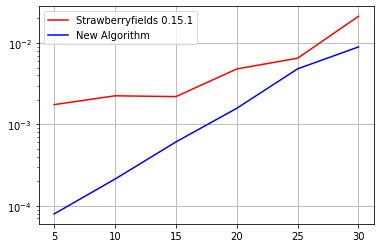

In [44]:
from matplotlib import pyplot as plt
plt1 = plt.plot(x,time_list_sf,'r');
plt2 = plt.plot(x,time_list_2mode,'b');
# plt3 = plt.plot(x,time_list_2mode2,'y');
plt.yscale('log')
plt.grid(True)
plt.legend((plt1[0],plt2[0]),("Strawberryfields 0.15.1","New Algorithm"))